# Chapter 7
## Moving Beyond Linearity

Relaxing the linearity assumption while still maintaining as much interpretibility as possible.

__1. Polynomial Regression__ :- Extends the linear model by adding extra predictors, obtained by raising each of the original predictors to a power.


__2. Step Functions__ :- Cut the range of a variable into K distinct regions in order to produce a qualitative variable. This has the effect of fitting a piecewise constant function.


__3. Regression Splines__ :- Dividing a variable to K distinct regions. Within each region, a polynomial is fit to data. The polynomial join smoothly at region boundaries called knots. 


__4. Smoothing Splines__ :- They result from minimizing a RSS criterion subject to smoothness penalty.


__5. Local Regression__ :- Similar to splines but the region are allowed to overlap.


__6. Generalized Additive Models__ :- Extend the above method to deal with multiple predictors.

### Polynomial Regression 
A polynomial regression model can be written as 
$$y_i = \beta_0 + \beta_1 x_{i} +  \beta_2 x_{i}^{2} +....+ \beta_d x_{i}^{d} + \epsilon_i$$
$\epsilon_i$ = error term.

large value of d means more flexible curve especially near the boundary of X. hence it is unusual to use d greater than 3 or 4. 

The coefficients can be estimated using least squares. Least squares returns varaince estimates for each fitted coefficients $\hat \beta_j$

If $l_o$ is the point estimate = $(1,x_0,x_{0}^{2},..)$ and C is the covaraince matrix then pointwise standard error can be written as $l_{0}^{T}Cl_0$.
This can be used to estimate the CI.


In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as stats
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.gam.api import GLMGam, BSplines
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import pygam
from sklearn.metrics import mean_squared_error
from patsy import dmatrix
from scipy.interpolate import interp1d

In [2]:
# Readin wage data in our environment.
url = "https://raw.githubusercontent.com/atystats/ISLR_Notes_codes/master/Datasets/Wage.csv"
Wage = pd.read_csv(url, index_col = 0, error_bad_lines = False)
Wage["Wage_250"] = 0
Wage.loc[Wage.wage > 250, "Wage_250"] = 1 # Creating binary variable for logistic model

In [114]:
X = np.array(Wage["age"]).reshape(-1,1)
y = np.array(Wage["wage"])
polynomial_features= PolynomialFeatures(degree=4)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y,xp).fit() # Fitting a linear model with polynomial terms

y = np.array(Wage["Wage_250"])
logit_model = sm.Logit(y,xp).fit() # Fitting a logistic regression model with polynomial terms


Optimization terminated successfully.
         Current function value: 0.116870
         Iterations 12


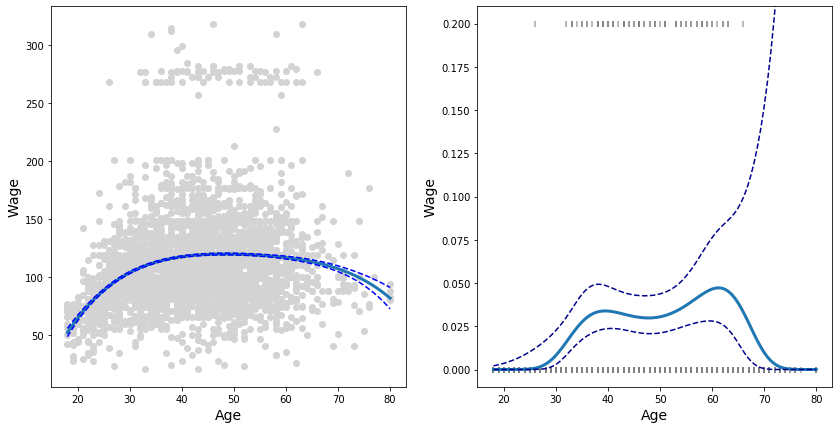

In [115]:
age_lin = np.linspace(min(Wage.age), max(Wage.age), 100)
age_poly = polynomial_features.fit_transform(age_lin.reshape(-1,1))

prediction = model.get_prediction(age_poly) # Getting the prediction interval for the linear model
CI = prediction.summary_frame(alpha = 0.5)

fig = plt.figure(figsize = (14,7))
ax1 = fig.add_subplot(121)
ax1.scatter(Wage.age, Wage.wage, color = "lightgrey")
ax1.plot(age_lin, model.predict(age_poly), linewidth = 3.0)
ax1.plot(age_lin, CI.mean_ci_lower, linestyle = "--", color = "blue")
ax1.plot(age_lin, CI.mean_ci_upper, linestyle = "--", color = "blue")
ax1.set_xlabel("Age", fontsize = 14)
ax1.set_ylabel("Wage", fontsize = 14)

# Prediction interval for the logistic regression model.
l0 = np.dot(age_poly,logit_model.params)
std_error = np.array([np.sqrt(np.dot(np.dot(g,logit_model.cov_params()),g)) for g in age_poly])
upper = l0 + 2 * std_error
lower = l0 - 2 * std_error
upper = np.exp(upper)/(1 + np.exp(upper))
lower = np.exp(lower)/(1 + np.exp(lower))

ax2 = fig.add_subplot(122)
ax2.scatter(Wage.age, Wage.Wage_250/5, color = "grey", marker = "|", alpha = 0.7)
ax2.plot(age_lin, logit_model.predict(age_poly), linewidth = 3.0)
ax2.plot(age_lin, lower, linestyle = "--", color = "darkblue")
ax2.plot(age_lin, upper, linestyle = "--", color = "darkblue")
ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel("Age", fontsize = 14)
ax2.set_ylabel("Wage", fontsize = 14)
plt.show()

The above plot shows how the prediction interval becomes wider at the edge of X variable. This happens because the at the extremes there are usually less observations and hence high variance in the estimates also the polynomial regression impose a global structure on the function of X so we can't control the shape where there is less no. of data.

### Step Functions
Step function breaks X into bins and fit a different constant in each bin. This amounts to converting a continous variable into ordered categorical variable. 

We create cut points $c_1,c_2, ... ,c_k$ in range of X, then construct K+1 new variables.
$$C_0(X) = I(X<c_1)$$
$$C_1(X) = I(c_1\le X\le c_2)$$
$$C_2(X) = I(c_2\le X\le c_3)$$
$$.....$$
$$C_{k-1}(X) = I(c_{k-1}\le X\le c_k)$$
$$C_k(X) = I(X \ge c_k)$$
Where I(.) = indicator function.

Finally, the linear equation can be written as 
$$y_i = \beta_0 + \beta_1 C_1(x_{i}) +  \beta_2 C_2(x_{i}) +....+ \beta_k C_k(x_{i}) + \epsilon_i$$

For X < $c_1$, all the predictors are zero so $\beta_0$ can be interpreted as mean value of Y for X < $c_1$.
$$y_i = \beta_0 + \beta_j\ \ \ for\ \ \ c_j \le X \le c_{j+1}$$
$\beta_j$ = average increase in response for X in $c_j \le X \le c_{j+1}$ relative to $X < c_1$

A similar logistic model would be 
$$P(y_i>c|x_i) = \frac{exp(\beta_0 + \beta_1 C_1(x_{i}) +  \beta_2 C_2(x_{i}) +....+ \beta_k C_k(x_{i}))}{1 + exp(\beta_0 + \beta_1 C_1(x_{i}) +  \beta_2 C_2(x_{i}) +....+ \beta_k C_k(x_{i}))}$$

However, selecting bins can be challenging unless there are natural breakpoints in predictors.

In [116]:
# Creating new variable with cut points at 30,50 and 65.
Wage["Age_30_50"] = 0
Wage.loc[(Wage.age > 30) & (Wage.age < 50), "Age_30_50"] = 1
Wage["Age_50_65"] = 0
Wage.loc[(Wage.age >= 50) & (Wage.age < 65), "Age_50_65"] = 1
Wage["Age_ge_65"] = 0
Wage.loc[Wage.age >= 65, "Age_ge_65"] = 1
X = np.array(Wage[["Age_30_50","Age_50_65","Age_ge_65"]])
X = sm.add_constant(X)
y = np.array(Wage["wage"])

model = sm.OLS(y,X).fit() # Fitting a linear model with step functions

y = np.array(Wage["Wage_250"])
logit_model = sm.Logit(y,X).fit() # Fitting a logistic regression model with step functions

Optimization terminated successfully.
         Current function value: 0.117675
         Iterations 10


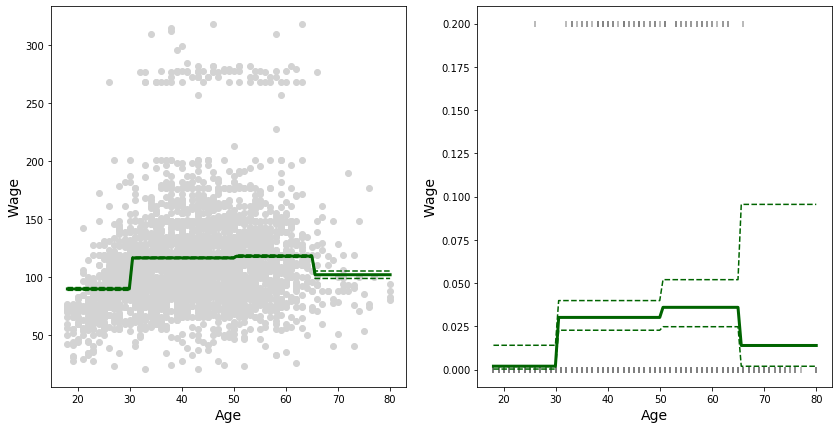

In [124]:
age = np.linspace(min(Wage.age), max(Wage.age), 100)
test_data = pd.DataFrame({"age":age})

test_data["Age_30_50"] = 0                          
test_data.loc[(test_data.age > 30) & (test_data.age < 50), "Age_30_50"] = 1
test_data["Age_50_65"] = 0
test_data.loc[(test_data.age >= 50) & (test_data.age < 65), "Age_50_65"] = 1
test_data["Age_ge_65"] = 0
test_data.loc[test_data.age >= 65, "Age_ge_65"] = 1 
test_X = np.array(test_data[["Age_30_50","Age_50_65","Age_ge_65"]])
                          
test_X = sm.add_constant(test_X)

prediction = model.get_prediction(test_X) # Getting the prediction interval for the linear model
CI = prediction.summary_frame(alpha = 0.5)

fig = plt.figure(figsize = (14,7))
ax1 = fig.add_subplot(121)
ax1.scatter(Wage.age, Wage.wage, color = "lightgrey")
ax1.plot(age, model.predict(test_X), linewidth = 3.0, color = "darkgreen")
ax1.plot(age, CI.mean_ci_lower, linestyle = "--", color = "darkgreen")
ax1.plot(age, CI.mean_ci_upper, linestyle = "--", color = "darkgreen")
ax1.set_xlabel("Age", fontsize = 14)
ax1.set_ylabel("Wage", fontsize = 14)

# Prediction interval for the logistic regression model.
l0 = np.dot(test_X,logit_model.params)
std_error = np.array([np.sqrt(np.dot(np.dot(g,logit_model.cov_params()),g)) for g in test_X])
upper = l0 + 2 * std_error
lower = l0 - 2 * std_error
upper = np.exp(upper)/(1 + np.exp(upper))
lower = np.exp(lower)/(1 + np.exp(lower))

ax2 = fig.add_subplot(122)
ax2.scatter(Wage.age, Wage.Wage_250/5, color = "grey", marker = "|", alpha = 0.7)
ax2.plot(age, logit_model.predict(test_X), linewidth = 3.0, color = "darkgreen")
ax2.plot(age, lower, linestyle = "--", color = "darkgreen")
ax2.plot(age, upper, linestyle = "--", color = "darkgreen")
ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel("Age", fontsize = 14)
ax2.set_ylabel("Wage", fontsize = 14)
plt.show()

We can see that between the cutpoints the prediction curve is flat. This is called __piecewise-constant regression__ model.

### Basis Functions
Instead of using X, use a function of X b(X) as input in the model. Polynomial and piecewise-constant regression is a special case of basis function.
$$y_i = \beta_0 + \beta_1 b_1(x_{i}) +  \beta_2 b_2(x_{i}) +....+ \beta_k b_k(x_{i}) + \epsilon_i$$

Basis function are fixed and known. We can use least squares to estimate them and hence all the inference tool for linear models can be applied.

### Regression Splines

__1. Piecewise Polynomial__ :-
It involves fitting seperate low degree polynomials. For eg. a polynomial equation can be written as
$$y_i = \beta_0 + \beta_1 x_i + .... + \beta_nx_i^2 + \epsilon_i$$

In piecewise regression $\beta's$ will change in different regions of X. The point where coefficients changes are called knots.

$$y_i = \beta_{01} + \beta_{11} x_i + .... + \beta_{n1} x_i^n + \epsilon_i , x_i < c$$
$$y_i = \beta_{02} + \beta_{12} x_i + .... + \beta_{n2} x_i^n + \epsilon_i , x_i \ge c$$
* We are fitting 2 different polynomials for 2 different regions of X each can be fitted using least squares.
* More knots means more flexible piecewise polynomial. 
* K knots means we are fitting K+1 functions.

__2. Constraints and Splines__ :-
A piecewise polynomial can look ridiculous because the curve won't be smooth at the knots and could take a weird shape. To solve this, we use some constraints to make it continous. 

Each constraint is going to free one degree of freedom. 

* A piecewise polynomial with constraints about continuity in derivative upto degree d-1 at each knot is a __degree d spline__.

__3. The Spline Basis Representation__ :-
To fit a model with piecewise regression under the constraints that it be continous? We can use a basis model to represent such model.

For e.g. A cubic spline with k knots
$$y_i = \beta_0 + \beta_1 b_1(x_i) + \beta_2 b_2(x_i) + .... + \beta_{K+3}b_{K+3}(x_i) + \epsilon_i$$
for an appropriate choice of basis function $b_1, b_2, ... , b_{K+3}$. 

The idea is to start with a basis for a cubic polynomial $(x,\ x^2,\ x^3)$ and then add one truncated power basis function per knot. 

$$h(x,\eta) = (x - \eta)_{+}^{3} = (x - \eta)^{3}\ if\ x > \eta,\ 0\ \ otherwise$$ 
where $\eta$ is the knot.

Adding a term of the form $\beta_4h(x,\eta)$ to the model for a cubic polynomial will lead to a discontinuity in only third derivative at $\eta$ and the function will remain continous at first and second derivative at each knots.

In total we have an intercept and 3 + K predictors.

One drawback of the splines is that it can have very high variance at the outer range of the predictors.

A __natural spline__ is a regression spline with additional boundary constraints, the function needs to be linear at the boundary.

This additional constraint means the natural splines generally produce more stable estimates at the boundaries.

In [71]:
# Cubic Spline
# Defining the X matrix for Cubic Spline
X_spline = dmatrix("bs(Wage.age, knots = (25,40,60), degree = 3, include_intercept = False)",
                   {"Wage.age":Wage.age}, return_type = "dataframe")
model_CS = sm.GLM(Wage.wage, X_spline).fit()

# Natural Spline 
# Defining the X matrix for Natural Spline
X_Nspline = dmatrix("cr(Wage.age, df = 6)",
                   {"Wage.age":Wage.age}, return_type = "dataframe")
model_NS = sm.GLM(Wage.wage, X_Nspline).fit()

age_lin = np.linspace(min(Wage.age), max(Wage.age), 100)

# Prediction for Cubic Spline
predict_CS = model_CS.predict(dmatrix("bs(age_lin, knots = (25,40,60), degree = 3, include_intercept = False)",
                   {"age_lin":age_lin}, return_type = "dataframe"))
prediction_CS = model_CS.get_prediction(dmatrix("bs(age_lin, knots = (25,40,60), degree = 3, include_intercept = False)",
                   {"age_lin":age_lin}, return_type = "dataframe"))

# Prediction for Natural Spline
predict_NS = model_NS.predict(dmatrix("cr(age_lin, df = 6)",
                   {"age_lin":age_lin}, return_type = "dataframe"))
prediction_NS = model_NS.get_prediction(dmatrix("cr(age_lin, df = 6)",
                   {"age_lin":age_lin}, return_type = "dataframe"))

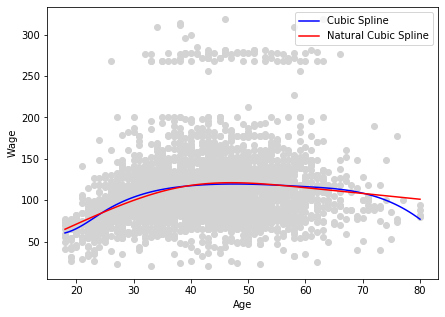

In [91]:
plt.figure(figsize = (7,5))
plt.scatter(Wage.age, Wage.wage, color = "lightgrey")
plt.plot(age_lin, predict_CS, color = "b", label = "Cubic Spline")
plt.plot(age_lin, predict_NS, color = "r", label = "Natural Cubic Spline")
plt.xlabel("Age")
plt.ylabel("Wage")
plt.legend()
plt.show()

__4. Choosing the number and location of knots__ :- 
* Regression spline is more flexible where we have more knots. So we can place more knots in the region where we feell the function might vary most rapidly.
* In practice, knots are placed uniformly usually by quantile of data.
* To understand how many knots are required, one option is to try out different numbers of knots and see what produce the best curve using cross validation.

In [117]:
# Defining the X matrix for Natural Spline
X_Nspline = dmatrix("cr(Wage.age, df = 5)",
                   {"Wage.age":Wage.age}, return_type = "dataframe")

#Linear Regression
model_NS = sm.GLM(Wage.wage, X_Nspline).fit()

predict_NS = model_NS.predict(dmatrix("cr(age_lin, df = 5)",
                   {"age_lin":age_lin}, return_type = "dataframe"))
prediction_NS = model_NS.get_prediction(dmatrix("cr(age_lin, df = 5)",
                   {"age_lin":age_lin}, return_type = "dataframe"))
CI = prediction_NS.summary_frame(alpha = 0.05)

# Logistic Regression
logit_NS = sm.Logit(Wage.Wage_250, X_Nspline).fit()

logit_predict_NS = logit_NS.predict(dmatrix("cr(age_lin, df = 5)",
                   {"age_lin":age_lin}, return_type = "dataframe"))

test_X = np.array(dmatrix("cr(age_lin, df = 5)",
                   {"age_lin":age_lin}, return_type = "dataframe"))

l0 = np.dot(test_X,logit_NS.params)
std_error = np.array([np.sqrt(np.dot(np.dot(g,logit_NS.cov_params()),g)) for g in test_X])
upper = l0 + 2 * std_error
lower = l0 - 2 * std_error
upper = np.exp(upper)/(1 + np.exp(upper))
lower = np.exp(lower)/(1 + np.exp(lower))

Optimization terminated successfully.
         Current function value: 0.116745
         Iterations 11


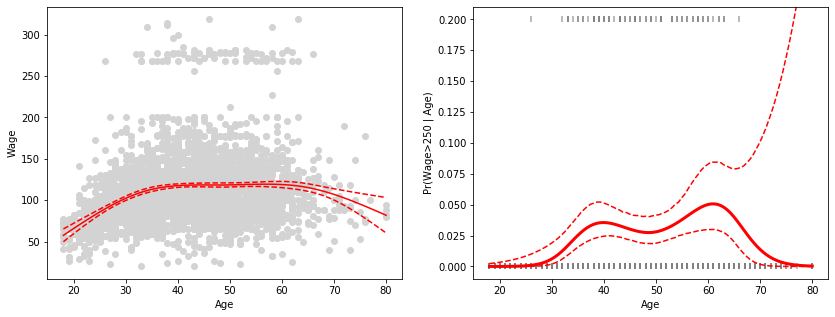

In [127]:
fig = plt.figure(figsize = (14,5))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(Wage.age, Wage.wage, color = "lightgrey")
ax1.plot(age_lin, predict_NS, color = "r")
ax1.plot(age_lin, CI.mean_ci_lower, color = "r", linestyle = "--")
ax1.plot(age_lin, CI.mean_ci_upper, color = "r", linestyle = "--")
ax1.set_xlabel("Age")
ax1.set_ylabel("Wage")

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(Wage.age, Wage.Wage_250/5, color = "grey", marker = "|", alpha = 0.7)
ax2.plot(age_lin, logit_predict_NS, linewidth = 3.0, color = "r")
ax2.plot(age_lin, lower, linestyle = "--", color = "r")
ax2.plot(age_lin, upper, linestyle = "--", color = "r")
ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel("Age")
ax2.set_ylabel("Pr(Wage>250 | Age)")
plt.show()

In [157]:
# Cross Validation for selecting the degrees of freedom.
MSE = []
for i in range(3,11):
    X = dmatrix("".join(["cr(Wage.age, df = ",str(i),")"]), {"Wage.age":Wage.age}, return_type = "dataframe")
    model = sm.GLM(Wage.wage, X).fit()
    MSE.append(mean_squared_error(Wage.wage, model.predict(X)))
print("MSE for Natural Spline")
print(MSE)
MSE = []
for i in range(3,11):
    X = dmatrix("".join(["bs(Wage.age, df = ", str(i),", degree = 3, include_intercept = False)"]),
                   {"Wage.age":Wage.age}, return_type = "dataframe")
    model = sm.GLM(Wage.wage, X).fit()
    MSE.append(mean_squared_error(Wage.wage, model.predict(X)))

print("MSE for Cubic Spline")
print(MSE)

MSE for Natural Spline
[1602.6078706803874, 1594.2434330646443, 1588.8790610734181, 1588.3725823550035, 1588.3006307332348, 1586.0362661952915, 1586.0935151922436, 1586.0511099965604]
MSE for Cubic Spline
[1592.55813365013, 1591.0332369388123, 1588.7901015292784, 1588.7481559342211, 1588.4572604798514, 1587.8549104628328, 1586.83484890014, 1584.669924518538]


In both the cases, it looks like there is no further improvement from degree 3 onwards.

__5. Comparison to Polynomial Regression__ :-
* Splines can perform better than polynomial regression as it can produce flexible curve without using higher degrees of freedom.
* Also, splines gives more flexibility by fitting complex curve in region of X where f changes rapidly by using more knots.
* The extra flexibility at the boundary region of X helps producing better results than polynomial regression.

In [158]:
# Polynomial Regression
X = np.array(Wage["age"]).reshape(-1,1)
y = np.array(Wage["wage"])
polynomial_features= PolynomialFeatures(degree=15)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y,xp).fit() # Fitting a linear model with polynomial terms

# Natural Spline
X_Nspline = dmatrix("cr(Wage.age, df = 5)",
                   {"Wage.age":Wage.age}, return_type = "dataframe")

model_NS = sm.GLM(Wage.wage, X_Nspline).fit()

predict_NS = model_NS.predict(dmatrix("cr(age_lin, df = 5)",
                   {"age_lin":age_lin}, return_type = "dataframe"))

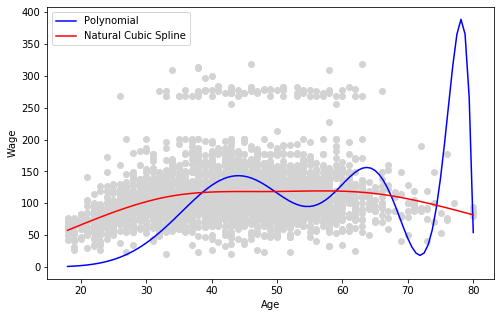

In [166]:
age_poly = polynomial_features.fit_transform(age_lin.reshape(-1,1))
plt.figure(figsize = (8,5))
plt.scatter(Wage.age, Wage.wage, color = "lightgrey")
plt.plot(age_lin, model.predict(age_poly), color = "b", label = "Polynomial")
plt.plot(age_lin, predict_NS, color = "r", label = "Natural Cubic Spline")
plt.xlabel("Age")
plt.ylabel("Wage")
plt.legend()
plt.show()

The above plot shows a polynomial curve with df = 15 and a natural cubic spline. Polynomial is showing a wild behaviour especially near the end.

### Smoothing Splines

In fitting a curve, our objective is to find a function g(x) that fits the observed data well, i.e. we want $RSS = \sum(y_i - g(x_i))^2$ to be small but if we put no constraints on g(x) it interpolates all of $y_i's$ and cause 
overfitting. g( ) should make RSS small and also smooth.

To ensure g is smooth, find g that minimizes 
$$\sum(y_i - g(x_i))^2 + \lambda \int g^{''}(t)^2dt$$
The above formula is "Loss + Penalty".
$\lambda$ - non-negetive tuning parameter. The g( ) that minimizes the function is called smoothing spline.

$\sum(y_i - g(x_i))^2$ = loss function.

$\lambda \int g^{''}(t)^2dt$ = penalty term that penalizes the variability in g.

The notation $g^{''}(t)$ indicates the second derivative (It represent the amount by which the slope is changing). The second derivative is the measure of roughness.

* If it is large in absolute value, g(t) is very wiggly near t and it is close to zero otherwise.
* $\int g^{''}(t)^2dt$ = measure of the total change in the function $g'(t)$ over its entire range.
* If g is grumpy and variable, g'(t) will vary significantly and $\int g^{''}(t)^2dt$ will take large value and vice versa.
* larger the $\lambda$, smoother the g will be.

$\lambda$ = 0, no penalty, g will be grumpy and exactly interpolates training observations.

$\lambda$ = $\infty$, g will be perfectly smooth and it will be a straight line.

For intermediate $\lambda$, g will approximate the training observation but will also be smooth. $\lambda$ controls bias-variance trade off of the smoothing splines.

Properties of g(x) that minimizes the above equation:-
1. It is a piecewise cubic polynomial with knots at uniques values of $x_1, x_2, ... , x_n$ and continous first and second derivative at each knot.
2. It is linear in region outside the extreme knots.
3. It is natural cubic spline.

__Choosing $\lambda$__

As $\lambda$ increase, roughness decrease and the degrees of freedom (no. of free parameters such as no. of coefficients fit in a polynomial and cubic spline) decreases.

A smoothing spline has n parameters and hence n degrees of freedom, these n parameters are heavily constrained or shrunken down, so $\lambda$ controls the roughness and effective degrees of freedom. Hence $df_{\lambda}$(effective degrees of freedom) is a measure of flexibility.

$df_{\lambda}$ increase, flexibility increase, low bias and high variance.

__Calculating effective degrees of freedom__
we can write $$\hat g_{\lambda} = S_{\lambda} y$$
$\hat g$ is the solution of the smoothing spline equation. It is a n-vector contained the fitted values of smoothing spline.

Vectors of fitted value when applying a smoothing spline to the data can be written as nXn matrix $S_{\lambda}$ times the response vector y.

Then effective degrees of freedom
$$df_{\lambda} = \sum_{i = 1}^{n}(S_{\lambda})_{ii}$$
the sum of diagonal elements.

* In fitting a smoothing spline, we do not need to select the no. of knots, there will be each knot at each training obs.. We need to choose $\lambda$.
* Cross validation can be used for that purpose.
* LOOCV can be used effectively using 
$$RSS_{CV}(\lambda) = \sum_{i = 1}^{n}(y_i - \hat g_{\lambda}^{(-i)}(x_i))^2 = \sum_{i = 1}^{n}[\frac{y_i - \hat g_{\lambda}(x_i)}{1 - (S_{\lambda})_{ii}}]^2$$
$\hat g_{\lambda}^{(-i)}(x_i)$ indicates the fitted value evaluated at $x_i$.

### Local Regression
Fitting flexible non-linear functions which involves computing the fit at a target point $x_0$ using only the near training observations.

1. Gather the fraction s = K/n of training points whose $x_i$ are closest to $x_0$.
2. Assign a weight $K_{i0} = K(x_i,x_0)$ to each point in this neighbourhood, so that the point furthest from $x_0$ has weight zero, and the closest has the highest weight. All but these K nearest neighbours get weight zero.
3. Fit a weighted least squares regression of the $y_i$ on the $x_i$ using the aformentioned weights by finding $\hat \beta_0$ and $\hat \beta_1$ that minimizes $$\sum_{i = 1}^{n}K_{i0}(y_i - \beta_0 - \beta_1x_i)^2$$
4. The fitted value at $x_0$ is given by $$\hat f(x_0) = \hat \beta_0 + \hat \beta_1x_0$$

Local regression is referred to as a memory - based approach, because like nearest - neighbour we need all the training data each time we wish to compute a prediction.
* Step 3 can also have a more complex curve rather than linear.
* Value of s(span) is most important. When s increase, flexibility decrease (fitting a global fit). When s decrease, flexibility increase (fitting a wiggly curve, more local fit).
* Cross validation can be used to choose s.

In case of multiple features, our fit can be global in some variables and local in others.

* Local regression also generalize when model is local in a pair of variables $X_1$ and $X_2$ rather than one. Use a 2-dimensional neighbour and fit a bivariate model. Same logic can be used for p-dimensional. However, local regression performs poorly if p > 3 or 4 as there will be less observation around $x_0$.

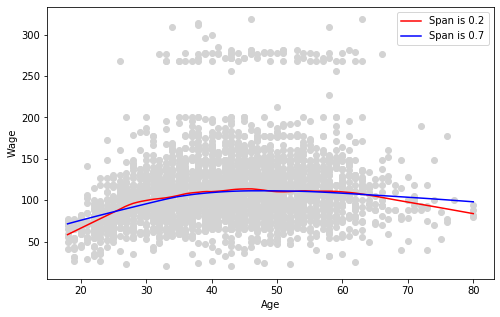

In [21]:
# Local linear regression
X = np.array(Wage["age"])
y = np.array(Wage["wage"])
lowess = sm.nonparametric.lowess
model_20 = lowess(y,X,frac=2./10.,it=3, return_sorted = True) # model with span 0.2
model_70 = lowess(y,X,frac=7./10.,it=3, return_sorted = True) # model with span 0.7

lowess_x_20 = list(zip(*model_20))[0] # X matrix sorted on y
lowess_y_20 = list(zip(*model_20))[1] # fitted value of y

lowess_x_70 = list(zip(*model_70))[0] # X matrix sorted on y
lowess_y_70 = list(zip(*model_70))[1] # fitted value of y

f_20 = interp1d(lowess_x_20, lowess_y_20, bounds_error=False) # fitting a curve using the fitted value of y
f_70 = interp1d(lowess_x_70, lowess_y_70, bounds_error=False) # fitting a curve using the fitted value of y
 
age_lin = np.linspace(min(Wage.age), max(Wage.age), 100)

plt.figure(figsize = (8,5))
plt.scatter(Wage.age, Wage.wage, color = "lightgrey")
plt.plot(age_lin, f_20(age_lin), color = "r", label = "Span is 0.2")
plt.plot(age_lin, f_70(age_lin), color = "b", label = "Span is 0.7")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Wage")
plt.show()

### Generalized Additive Models
GAMs provide a general framework for extending a standard linear model by allowing non-linear functions of each of the variables while maintaining additivity. It can be applied with both quantitative and qualitative responses.

__GAMs for regression problems__:-

A GAM can be written as 
$$y_i = \beta_0 + \sum_{j = 1}^{p}f(x_{ij}) + \epsilon_i$$
It is called an additive model because we calculate a seperate $f_j$ for each $X_j$ and then add together all of their contributions.

All the methods that have discussed to fit a single variable. These methods can be used as building blocks of an additive model. For e.g. $y = \beta_0 + f_1(X_1) + f_2(X_2) + f_3(X_3) + \epsilon$.
$f_1$ and $f_2$ can be smoothing spline and $f_3$ can be a linear effect model. 

__Advantage__
1. Allow us to fit a non-linear $f_i$ to each $X_j$ so that we can automatically model non-linear relationship that standard linear regression will miss.
2. can improve the fit.
3. GAMs are interpretable as well.
4. Smoothness can be summarized via degrees of freedom.

__Disadvantage__
1. GAM is restricted to be additive, and can miss the interaction (but they can be added seperately).

__GAMs for classification__

GAMs can be used for qualitative Y as well
$$log(\frac{P(X)}{1-P(X)}) = \beta_0 + f_1(X_1) + f_2(X_2) + .... + f_p(X_p)$$

## Lab : Non-linear Modeling
### Polynomial Regression and Step Functions

In [15]:
X = np.array(Wage["age"]).reshape(-1,1)
y = np.array(Wage["wage"])
polynomial_features= PolynomialFeatures(degree=4)
xp = polynomial_features.fit_transform(X)
model = sm.OLS(y,xp).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                Tue, 07 Jul 2020   Prob (F-statistic):           2.77e-57
Time:                        19:27:29   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -184.1542     60.040     -3.067      0.002    -301.879     -66.430
x1            21.2455      5.887      3.609      0.000       9.703      32.788
x2            -0.5639      0.206     -2.736      0.006      -0.968      -0.160
x3             0.0068      0.003      2.221      0.026       0.001       0.013
x4         -3.204e-05   1.64e-05     -1.952      0.051   -6.42e-05    1.45e-07
==============================================================================
Omnibus:                     1097.594   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4965.521
Skew:                           1.722   Prob(JB):                         0.00
Kurtosis:                       8.279   Cond. No.                     5.67e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.67e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In the above model, we need to nete that PolynomialFeatures create a matrix whose columns are basis of orthogonal polynomial which means that each column is a linear combination of (age, age^2, age^3 and age^4). To fit the model on the raw variable we have to mention each polynomial seperately.

To decide on what degree of polynomial to use in the model, we can use hypothesis testing. We will perform anova in order to test the hypothesis that model $M_1$ is sufficient to explain the data. 

In [54]:
wage_data = pd.DataFrame(xp, columns = ["Intercept","age", "age_2","age_3", "age_4"])
wage_data["wage"] = Wage["wage"]
model1 = smf.ols("wage ~ age", data = wage_data).fit()
model2 = smf.ols("wage ~ age + age_2", data = wage_data).fit()
model3 = smf.ols("wage ~ age + age_2 + age_3", data = wage_data).fit()
model4 = smf.ols("wage ~ age + age_2 + age_3 + age_4", data = wage_data).fit()
anovaresult = sm.stats.anova_lm(model1, model2, model3, model4)
print(anovaresult)

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.602458  2.353254e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.889400  1.678616e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.810061  5.103865e-02


* The p value for model1 comparing to model2 is very small, i.e. model1 is not sufficient for the data. 
* The p value for model2 comparing to model3 is very small, i.e. model2 is also not sufficient for the data. 
* The p value for model3 comparing to model4 is close to 0.05, i.e. model3 could be used or polynomial of degree 3 could be used for the model.

However, in this case we don't need the anova as our polynomial are orthogonal. We can notice that the p values are very similar to the model output above.

ANOVA can be used even when we have other variables in the model.

In [59]:
wage_data["Wage_250"] = Wage["Wage_250"]
model_l4 = smf.logit("Wage_250 ~ age + age_2 + age_3 + age_4", data = wage_data).fit()
model_l4.summary()

Optimization terminated successfully.
         Current function value: 0.116870
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Wage_250   No. Observations:                 3000
Model:                          Logit   Df Residuals:                     2995
Method:                           MLE   Df Model:                            4
Date:                Wed, 08 Jul 2020   Pseudo R-squ.:                 0.04013
Time:                        01:17:04   Log-Likelihood:                -350.61
converged:                       True   LL-Null:                       -365.27
Covariance Type:            nonrobust   LLR p-value:                 6.747e-06
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -109.5530     47.655     -2.299      0.022    -202.956     -16.150
age            8.9950      4.187      2.148      0.032       0.789      17.201
age_2         -0.2816      0.135     -2.081      0.037      -0.547      -0.016
age_3          0.0039      0.002      2.022      0.043       0.000       0.008
age_4      -1.949e-05   9.91e-06     -1.966      0.049   -3.89e-05   -6.41e-08
==============================================================================
"""

In [63]:
model_l4.fittedvalues[:3]

0   -18.438198
1    -9.027252
2    -3.453538
dtype: float64

The fitted values above are the log odds of Y = 1 and not the probability. To get the probability we need to transform it exp(Xb)/(1 + exp(Xb)).

To fit a step function, we can use cut() function from pandas.

In [11]:
# Creating a categorical varaible with 4 bins.
Wage["age_step4"] = pd.cut(Wage.age, bins=4)
Wage["age_step4"].value_counts()

(33.5, 49.0]      1399
(49.0, 64.5]       779
(17.938, 33.5]     750
(64.5, 80.0]        72
Name: age_step4, dtype: int64

In [30]:
model_step1 = smf.ols("wage ~ age_step4", data = Wage).fit()
model_step1.summary2().tables[1]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,94.158392,1.476069,63.789970,0.000000e+00,91.264181,97.052603
"age_step4[T.Interval(33.5, 49.0, closed='right')]",24.053491,1.829431,13.148074,1.982315e-38,20.466424,27.640559
"age_step4[T.Interval(49.0, 64.5, closed='right')]",23.664559,2.067958,11.443444,1.040750e-29,19.609798,27.719320
"age_step4[T.Interval(64.5, 80.0, closed='right')]",7.640592,4.987424,1.531972,1.256350e-01,-2.138531,17.419714


### Splines

Splines code in python is already explained above under the Spline regression topic and so is local regression.

### GAMs
One way of fitting a GAM model is to use GLMGam from statsmodels. 

In [249]:
x_spline = Wage[["year","age"]] # Selecting variables for spline
bs4 = BSplines(x_spline, df=[5,6], degree=[3,3]) # Creating a spline for year and age variable with 4 and 5 df.

# This model has spline effect for age and year and average effect for education
gam_bs = GLMGam.from_formula('wage ~ education', data=Wage, 
                             smoother=bs4).fit() 

In [255]:
gam_bs.summary2().tables[1]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,48.111325,6.023707,7.986996,1.382665e-15,36.305076,59.917574
education[T.2. HS Grad],10.993625,2.431513,4.521310,6.145805e-06,6.227947,15.759303
education[T.3. Some College],23.471313,2.563827,9.154797,5.446021e-20,18.446305,28.496321
education[T.4. College Grad],38.262528,2.549848,15.005809,6.726582e-51,33.264918,43.260138
education[T.5. Advanced Degree],62.487040,2.761773,22.625696,2.421156e-113,57.074064,67.900016
year_s0,0.558590,3.989553,0.140013,8.886496e-01,-7.260790,8.377969
year_s1,10.109840,5.084122,1.988513,4.675503e-02,0.145145,20.074536
year_s2,3.583464,3.990048,0.898100,3.691320e-01,-4.236887,11.403816
year_s3,7.671403,2.342668,3.274644,1.057954e-03,3.079858,12.262948
age_s0,5.640474,9.475403,0.595275,5.516594e-01,-12.930974,24.211922


<Figure size 1008x504 with 0 Axes>

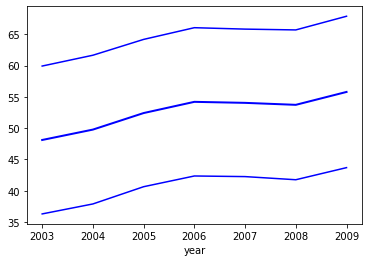

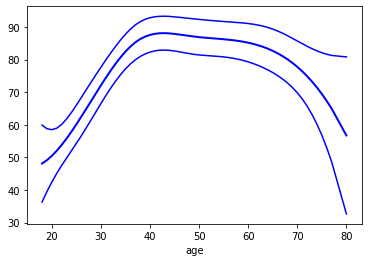

In [251]:
fig = plt.figure(figsize = (14,7))
ax1 = gam_bs.plot_partial(0,cpr = False)
ax2 = gam_bs.plot_partial(1,cpr = False)
plt.show()

Another way of building a GAMs is to use PyGAM.

In [283]:
Wage["education_dcd"] = Wage["education"].str[:1].astype('int64')
Wage["education_dcd"] = Wage["education_dcd"] - 1
X = np.array(Wage[["year","age","education_dcd"]]).astype("float64")
y = np.array(Wage.wage)
gam = pygam.LinearGAM(pygam.s(0, n_splines = 7) + pygam.s(1, n_splines = 12) + pygam.f(2)).gridsearch(X,y)
gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     13.0041
Link Function:                     IdentityLink Log Likelihood:                                -24117.1881
Number of Samples:                         3000 AIC:                                            48262.3842
                                                AICc:                                            48262.525
                                                GCV:                                             1245.8227
                                                Scale:                                           1236.1061
                                                Pseudo R-Squared:                                    0.293
Feature Function                  Lam

/Users/atyagi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  


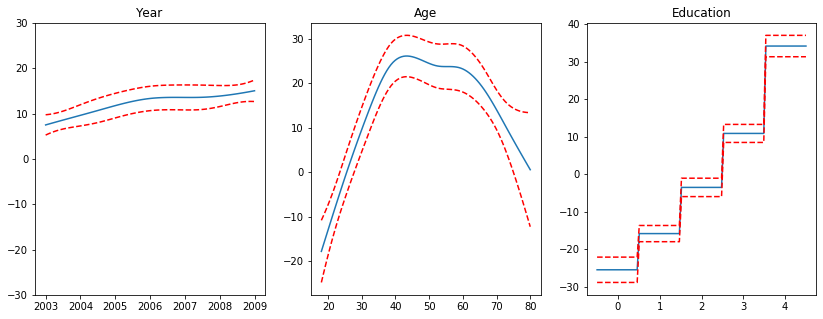

In [343]:
titles = ['year', 'age','education']
fig = plt.figure(figsize = (14,5))
ax1 = fig.add_subplot(1,3,1)
XX = gam.generate_X_grid(term=0)
ax1.plot(XX[:, 0], gam.partial_dependence(term=0, X=XX))
ax1.plot(XX[:, 0], gam.partial_dependence(term=0, X=XX, width=.95)[1], c='r', ls='--')
ax1.set_ylim(-30,30)
ax1.set_title("Year")

ax2 = fig.add_subplot(1,3,2)
XX = gam.generate_X_grid(term=1)
ax2.plot(XX[:, 1], gam.partial_dependence(term=1, X=XX))
ax2.plot(XX[:, 1], gam.partial_dependence(term=1, X=XX, width=.95)[1], c='r', ls='--')
ax2.set_title("Age")

ax3 = fig.add_subplot(1,3,3)
XX = gam.generate_X_grid(term=2)
ax3.plot(XX[:, 2], gam.partial_dependence(term=2, X=XX))
ax3.plot(XX[:, 2], gam.partial_dependence(term=2, X=XX, width=.95)[1], c='r', ls='--')
ax3.set_title("Education")
plt.show()

The p values of the spline in the model above is not significant. So, we might wants to drop that.

__GAMs for Classification__

In [330]:
X = np.array(Wage[["year","age","education_dcd"]]).astype("float64")
y = np.array(Wage.Wage_250)
Logit_gam = pygam.LogisticGAM(pygam.l(0) + pygam.s(1, n_splines = 12) + pygam.f(2)).gridsearch(X,y)
Logit_gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     10.1241
Link Function:                        LogitLink Log Likelihood:                                  -301.7388
Number of Samples:                         3000 AIC:                                              623.7259
                                                AICc:                                             623.8161
                                                UBRE:                                               2.2106
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1739
Feature Function                  Lam

/Users/atyagi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  after removing the cwd from sys.path.


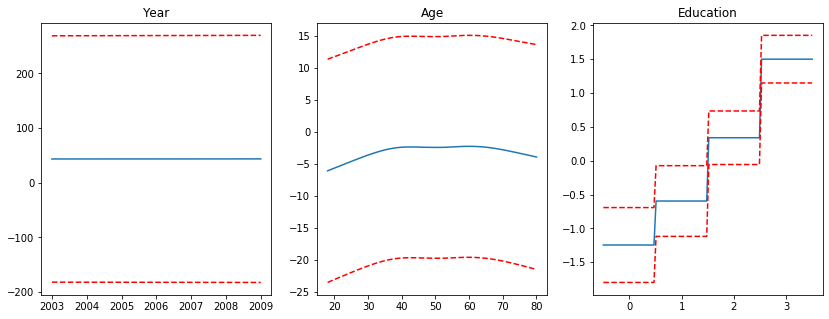

In [344]:
titles = ['year', 'age','education']
fig = plt.figure(figsize = (14,5))
ax1 = fig.add_subplot(1,3,1)
XX = Logit_gam.generate_X_grid(term=0)
pdep, confid = Logit_gam.partial_dependence(term=0, width = .95)
ax1.plot(XX[:, 0], pdep)
ax1.plot(XX[:, 0], confid, c='r', ls='--')
ax1.set_title("Year")

ax2 = fig.add_subplot(1,3,2)
XX = Logit_gam.generate_X_grid(term=1)
pdep, confid = Logit_gam.partial_dependence(term=1, width = .95)
ax2.plot(XX[:, 1], pdep)
ax2.plot(XX[:, 1], confid, c='r', ls='--')
ax2.set_title("Age")

ax3 = fig.add_subplot(1,3,3)
XX = Logit_gam.generate_X_grid(term=2)
pdep, confid = Logit_gam.partial_dependence(term=2, width = .95)
ax3.plot(XX[:, 2], pdep)
ax3.plot(XX[:, 2], confid, c='r', ls='--')
ax3.set_title("Education")
plt.show()

It can be seen in the above plots that the confidence interval is very high.
Also, in the last plot of education, the CI for class 0 is much higher than the other classes. This is because this class do not have any high earner. We will not plot removing that class.

In [336]:
Wage["education_dcd_new"] = Wage["education_dcd"] - 1
X = np.array(Wage[Wage.education_dcd_new != -1][["year","age","education_dcd_new"]]).astype("float64")
y = np.array(Wage[Wage.education_dcd_new != -1]["Wage_250"])
Logit_gam = pygam.LogisticGAM(pygam.l(0) + pygam.s(1, n_splines = 12) + pygam.f(2)).gridsearch(X,y)
Logit_gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      8.2747
Link Function:                        LogitLink Log Likelihood:                                  -302.3325
Number of Samples:                         2732 AIC:                                              621.2144
                                                AICc:                                             621.2844
                                                UBRE:                                               2.2298
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.155
Feature Function                  Lam

/Users/atyagi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """


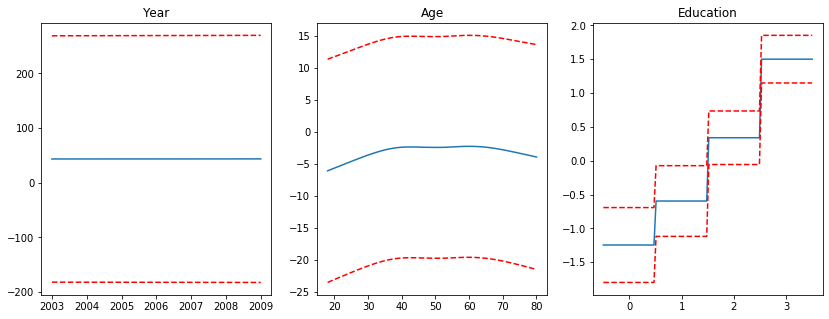

In [345]:
titles = ['year', 'age','education']
fig = plt.figure(figsize = (14,5))
ax1 = fig.add_subplot(1,3,1)
XX = Logit_gam.generate_X_grid(term=0)
pdep, confid = Logit_gam.partial_dependence(term=0, width = .95)
ax1.plot(XX[:, 0], pdep)
ax1.plot(XX[:, 0], confid, c='r', ls='--')
ax1.set_title("Year")

ax2 = fig.add_subplot(1,3,2)
XX = Logit_gam.generate_X_grid(term=1)
pdep, confid = Logit_gam.partial_dependence(term=1, width = .95)
ax2.plot(XX[:, 1], pdep)
ax2.plot(XX[:, 1], confid, c='r', ls='--')
ax2.set_title("Age")

ax3 = fig.add_subplot(1,3,3)
XX = Logit_gam.generate_X_grid(term=2)
pdep, confid = Logit_gam.partial_dependence(term=2, width = .95)
ax3.plot(XX[:, 2], pdep)
ax3.plot(XX[:, 2], confid, c='r', ls='--')
ax3.set_title("Education")
plt.show()

### Excercise
__Conceptual__